In [1]:

import networkx as nx
import pandas as pd
import numpy as np
import pulp
import itertools
import os
import pickle
from collections import deque
from tqdm import tqdm
import osmnx as ox
import matplotlib.pyplot as plt

In [2]:
with open('graph_from_routes_wd.pkl', 'rb') as f:
    graph_from_routes = pickle.load(f)
nyc_graph = graph_from_routes.copy()


In [3]:
len(nyc_graph.nodes())

482

In [4]:
# %%
import math
edge_info = {}
l = 50 #km/h#/ 3600#m/h
# Iterate over edges and add distances to the dictionary
for u, v, d in nyc_graph.edges(data=True):
    edge_info[(u, v)] = [
        int(d["length"]),
        d["length"] / d["maxspeed"] if not math.isnan(d["maxspeed"]) else d["length"]/l,
        50
    ]

In [5]:
edge_info

{(42433027, 42433020): [173, 6.946920000000001, 50],
 (42433020, 42433027): [173, 6.946920000000001, 50],
 (42433020, 42433014): [132, 2.64628, 50],
 (42433014, 42433020): [132, 2.64628, 50],
 (42433014, 42442671): [57, 1.15568, 50],
 (42442671, 42433014): [57, 1.15568, 50],
 (42442671, 42442664): [80, 1.6057599999999999, 50],
 (42442671, 42432999): [560, 11.212344164385478, 50],
 (42442664, 42442671): [80, 1.6057599999999999, 50],
 (42442664, 42432999): [57, 1.1411, 50],
 (42442664, 42442651): [401, 8.02766, 50],
 (42432999, 42442664): [57, 1.1411, 50],
 (42432999, 42432985): [415, 16.63452, 50],
 (42432999, 42442671): [560, 11.212344164385478, 50],
 (42432985, 42432999): [415, 16.63452, 50],
 (42432985, 42432963): [817, 32.709999999999994, 50],
 (42432985, 42442651): [155, 3.1176599999999994, 50],
 (42432963, 42432985): [817, 32.709999999999994, 50],
 (42432963, 42432929): [1627, 65.09828, 50],
 (42432963, 42434262): [273, 10.92076, 50],
 (42432929, 42432963): [1627, 65.09828, 50],
 

In [6]:
df = pd.read_csv("dataset/finished_dataset.csv")

In [7]:
unique_pickups = list(np.unique(df["pickup_graph_node"]))
unique_dropoffs = list(np.unique(df["dropoff_graph_node"]))
important_points= list(set(unique_dropoffs+unique_pickups))


In [8]:
# Retrieve the street network for Manhattan, but simplified
graph = ox.graph_from_place("Manhattan, New York, USA", network_type="drive_service", custom_filter='["highway"~"primary|secondary"]')


In [9]:
def cluster_nodes_within_radius(graph, radius):
    clusters = {}
    cluster_number = 1
    visited_nodes = set()

    for node in graph.nodes():
        if node not in visited_nodes:
            cluster = set()
            queue = deque([node])
            while queue:
                current_node = queue.popleft()
                if current_node not in cluster:
                    cluster.add(current_node)
                    visited_nodes.add(current_node)
                    neighbors = graph[current_node]
                    for neighbor, data in neighbors.items():
                        if data.get('length', 1) <= radius and neighbor not in visited_nodes:
                            queue.append(neighbor)
            clusters[cluster_number] = cluster
            cluster_number += 1
    
    return clusters

In [10]:
def get_cluster_coordinates(graph, clusters):
    cluster_coordinates = {}
    
    for cluster_number, nodes in clusters.items():
        x_sum = 0
        y_sum = 0
        for node in nodes:
            node_data = graph.nodes[node]
            x_sum += node_data['x']
            y_sum += node_data['y']
        x_avg = x_sum / len(nodes)
        y_avg = y_sum / len(nodes)
        cluster_coordinates[cluster_number] = (x_avg, y_avg)
    
    return cluster_coordinates

In [11]:

def create_cluster_edges(graph, clusters, nyc_clusters_nodes, og_graph):
    cluster_graph = nx.DiGraph()
    
    # Add nodes to the cluster graph
    for (cluster_number, nodes), node in zip(clusters.items(), nyc_clusters_nodes.values()):
        #node = node_elem[cluster_number]
        print(node)
        cluster_graph.add_node(cluster_number, x=og_graph.nodes[node]['x'], y=og_graph.nodes[node]['y'])
    
    # Iterate through original edges
    for u, v, data in graph.edges(data=True):
        # Find which clusters each endpoint belongs to
        u_cluster = None
        v_cluster = None
        for cluster_number, nodes in clusters.items():
            if u in nodes:
                u_cluster = cluster_number
            if v in nodes:
                v_cluster = cluster_number
        
        # If both endpoints belong to different clusters, add edge between the clusters
        if u_cluster is not None and v_cluster is not None and u_cluster != v_cluster:
            if cluster_graph.has_edge(u_cluster, v_cluster):
                # If an edge already exists between the clusters, update its attributes
                cluster_graph[u_cluster][v_cluster]['weight'] += 1
            else:
                # Otherwise, add a new edge
                cluster_graph.add_edge(u_cluster, v_cluster, weight=1)
    
    return cluster_graph


In [12]:
nyc_clusters = cluster_nodes_within_radius(nyc_graph, radius=160)  # Adjust radius as needed



In [13]:
print(len(nyc_graph.nodes()),len(nyc_clusters))

482 176


In [14]:
len(nyc_clusters.keys())

176

In [189]:
graph.nodes(data=True)

NodeDataView({42421728: {'y': 40.7980478, 'x': -73.9600437, 'highway': 'traffic_signals', 'street_count': 3}, 42421737: {'y': 40.7992437, 'x': -73.9628734, 'highway': 'traffic_signals', 'street_count': 4}, 42421741: {'y': 40.8004295, 'x': -73.9656909, 'highway': 'traffic_signals', 'street_count': 4}, 42421745: {'y': 40.8013981, 'x': -73.9679955, 'highway': 'traffic_signals', 'street_count': 4}, 42421749: {'y': 40.8016452, 'x': -73.9685741, 'highway': 'traffic_signals', 'street_count': 1}, 42421783: {'y': 40.8593291, 'x': -73.9313239, 'highway': 'traffic_signals', 'street_count': 3}, 42421951: {'y': 40.7033264, 'x': -74.0077746, 'highway': 'traffic_signals', 'street_count': 2}, 42422086: {'y': 40.8016439, 'x': -73.9333873, 'street_count': 1}, 42422283: {'y': 40.7094916, 'x': -74.001657, 'highway': 'traffic_signals', 'street_count': 4}, 42422592: {'y': 40.7849764, 'x': -73.9826519, 'highway': 'traffic_signals', 'street_count': 4}, 42422899: {'y': 40.7456883, 'x': -73.9721236, 'highway': 

In [15]:
nyc_cluster_coordinates = get_cluster_coordinates(graph, nyc_clusters)
nyc_clusters_nodes = {}
for i, (longitude, latitude) in nyc_cluster_coordinates.items():
    nearest_node = ox.distance.nearest_nodes(graph, longitude, latitude)
    nyc_clusters_nodes[i] = nearest_node

In [16]:
nyc_clusters_nodes

{1: 42433027,
 2: 42442671,
 3: 42442651,
 4: 42432963,
 5: 42432929,
 6: 6431058183,
 7: 42432894,
 8: 42433743,
 9: 3099327964,
 10: 595703226,
 11: 42446138,
 12: 596776260,
 13: 42446036,
 14: 42459137,
 15: 42436481,
 16: 596776032,
 17: 42445950,
 18: 42456611,
 19: 42445928,
 20: 100522741,
 21: 42437358,
 22: 561042192,
 23: 42436582,
 24: 7372860100,
 25: 42440729,
 26: 1773084402,
 27: 1918039904,
 28: 1773076511,
 29: 42437589,
 30: 42437996,
 31: 42451593,
 32: 42428473,
 33: 42428436,
 34: 272195270,
 35: 3914862593,
 36: 42432165,
 37: 42442889,
 38: 42440737,
 39: 42440743,
 40: 42439006,
 41: 9166033062,
 42: 4321748238,
 43: 42430237,
 44: 42430828,
 45: 42432214,
 46: 4205565514,
 47: 42435624,
 48: 42435644,
 49: 42435650,
 50: 42435663,
 51: 42435675,
 52: 42440001,
 53: 42435707,
 54: 1825841693,
 55: 1061531509,
 56: 7802856352,
 57: 42435275,
 58: 42427915,
 59: 7106818626,
 60: 42425232,
 61: 42421728,
 62: 3247295579,
 63: 42428590,
 64: 6207264908,
 65: 106153

In [17]:
nyc_graph.nodes[42433027]

{'id': 0, 'depot': False}

In [18]:
nyc_cluster_graph = create_cluster_edges(nyc_graph, nyc_clusters, nyc_clusters_nodes, graph)

42433027
42442671
42442651
42432963
42432929
6431058183
42432894
42433743
3099327964
595703226
42446138
596776260
42446036
42459137
42436481
596776032
42445950
42456611
42445928
100522741
42437358
561042192
42436582
7372860100
42440729
1773084402
1918039904
1773076511
42437589
42437996
42451593
42428473
42428436
272195270
3914862593
42432165
42442889
42440737
42440743
42439006
9166033062
4321748238
42430237
42430828
42432214
4205565514
42435624
42435644
42435650
42435663
42435675
42440001
42435707
1825841693
1061531509
7802856352
42435275
42427915
7106818626
42425232
42421728
3247295579
42428590
6207264908
1061531634
1061531454
1061531603
1061531807
42421745
42428782
6223571522
7480301865
7004393049
42440022
42440015
42445357
42423456
3891963915
42442451
42442469
42439464
42448707
42442902
42445390
42422899
1701844698
42442937
42438889
42430384
42430394
42423674
42434262
42442584
42442569
42421737
42443381
42443353
42443280
42443347
42443336
42439990
42437363
42439960
42437654
42437890

In [19]:
graph.nodes

NodeView((42421728, 42421737, 42421741, 42421745, 42421749, 42421783, 42421951, 42422086, 42422283, 42422592, 42422899, 42423020, 42423116, 42423295, 42423456, 42423674, 42423685, 42424025, 42424032, 42424089, 42424142, 42424218, 42424235, 42424439, 42424576, 42424619, 42424672, 42424703, 42424789, 42425188, 42425232, 42425348, 42425425, 42425747, 42425780, 42426135, 42426374, 42426665, 42426747, 42426875, 42426957, 42426968, 42427086, 42427133, 42427190, 42427216, 42427324, 42427327, 42427335, 42427358, 42427844, 42427859, 42427870, 42427877, 42427915, 42427926, 42427965, 42427968, 42428007, 42428020, 42428037, 42428201, 42428297, 42428329, 42428391, 42428436, 42428438, 42428447, 42428473, 42428575, 42428588, 42428590, 42428595, 42428634, 42428653, 42428674, 42428711, 42428714, 42428782, 42428863, 42428931, 42428956, 42428961, 42428962, 42428973, 42428984, 42429017, 42429023, 42429029, 42429215, 42429222, 42429314, 42429324, 42429330, 42429334, 42429338, 42429340, 42429342, 42429378, 

In [20]:
nyc_cluster_graph.nodes(data=True)

NodeDataView({1: {'x': -73.9398455, 'y': 40.8385135}, 2: {'x': -73.9401964, 'y': 40.8353595}, 3: {'x': -73.9429836, 'y': 40.8315772}, 4: {'x': -73.9447637, 'y': 40.8240402}, 5: {'x': -73.9525905, 'y': 40.8107673}, 6: {'x': -73.9529182, 'y': 40.807775}, 7: {'x': -73.9527337, 'y': 40.8041987}, 8: {'x': -73.955363, 'y': 40.7994668}, 9: {'x': -73.9525303, 'y': 40.7982754}, 10: {'x': -73.949736, 'y': 40.7970992}, 11: {'x': -73.9495058, 'y': 40.7936162}, 12: {'x': -73.9526692, 'y': 40.7866031}, 13: {'x': -73.959311, 'y': 40.780173}, 14: {'x': -73.9604288, 'y': 40.7756143}, 15: {'x': -73.9637208, 'y': 40.7710637}, 16: {'x': -73.9671492, 'y': 40.7667205}, 17: {'x': -73.9714224, 'y': 40.7635873}, 18: {'x': -73.9720733, 'y': 40.7596534}, 19: {'x': -73.975593, 'y': 40.7578582}, 20: {'x': -73.9757004, 'y': 40.7546355}, 21: {'x': -73.9808792, 'y': 40.7534805}, 22: {'x': -73.9800466, 'y': 40.7490228}, 23: {'x': -73.9842643, 'y': 40.7401675}, 24: {'x': -73.9883247, 'y': 40.7432751}, 25: {'x': -73.987

In [21]:
G = nyc_graph.copy()
for cluster_label, representative_node in nyc_clusters_nodes.items():
    cluster_nodes = [node for node, label in nyc_clusters.items() if label == cluster_label]
    for node in cluster_nodes:
        if node != representative_node:
            G = nx.contracted_nodes(G, representative_node, node, self_loops=False)


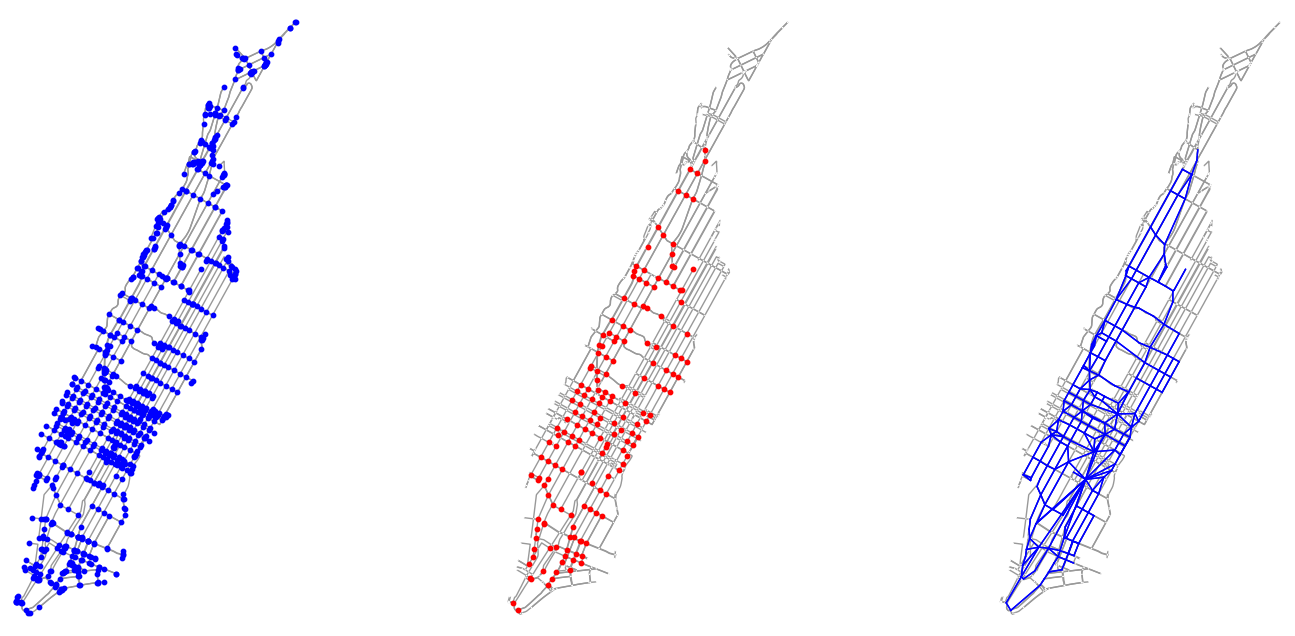

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 1 row, 2 columns
# Plot the second subplot
ax = axes[0]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for n in graph.nodes():
    ax.scatter(graph.nodes[n]['x'], graph.nodes[n]['y'], color='b', s=10)
# Plot the first subplot
ax = axes[1]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node in nyc_clusters_nodes.values():
    ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], color='r', s=10)

ax = axes[2]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node1, node2 in nyc_cluster_graph.edges():
    
    x1, y1 =nyc_cluster_coordinates[node1]
    x2, y2 = nyc_cluster_coordinates[node2]
    #print(node1, node2)
    # Get node coordinates
    #x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
    #x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
    # Plot edge
    ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed


#plt.tight_layout() 
#plt.savefig('cluster_visualization.png',dpi=300 )
#plt.show()


In [190]:
len(nyc_cluster_graph.edges())

620

In [191]:
len(graph.edges())

1799

In [215]:
import networkx as nx
backup_g = nyc_cluster_graph.copy()
def apply_transformation_rule(graph, important_nodes):
    # Iterate over all subgraphs in the graph
    for subgraph in nx.connected_components(graph):
        if len(subgraph) == 4:  # Check if the subgraph has exactly 4 nodes
            subgraph_nodes = list(subgraph)
            # Check if all nodes in the subgraph are not in important_nodes and only connected to each other
            if all(node not in important_nodes and set(graph.neighbors(node)) <= set(subgraph_nodes) for node in subgraph_nodes):
                # Remove nodes from the subgraph
                graph.remove_nodes_from(subgraph_nodes)


#apply_transformation_rule(backup, important_points)


In [216]:
len(backup_g.edges())

620

In [217]:
backup_g.nodes(data=True)

NodeDataView({1: {'x': -73.9398455, 'y': 40.8385135}, 2: {'x': -73.9401964, 'y': 40.8353595}, 3: {'x': -73.9429836, 'y': 40.8315772}, 4: {'x': -73.9447637, 'y': 40.8240402}, 5: {'x': -73.9525905, 'y': 40.8107673}, 6: {'x': -73.9529182, 'y': 40.807775}, 7: {'x': -73.9527337, 'y': 40.8041987}, 8: {'x': -73.955363, 'y': 40.7994668}, 9: {'x': -73.9525303, 'y': 40.7982754}, 10: {'x': -73.949736, 'y': 40.7970992}, 11: {'x': -73.9495058, 'y': 40.7936162}, 12: {'x': -73.9526692, 'y': 40.7866031}, 13: {'x': -73.959311, 'y': 40.780173}, 14: {'x': -73.9604288, 'y': 40.7756143}, 15: {'x': -73.9637208, 'y': 40.7710637}, 16: {'x': -73.9671492, 'y': 40.7667205}, 17: {'x': -73.9714224, 'y': 40.7635873}, 18: {'x': -73.9720733, 'y': 40.7596534}, 19: {'x': -73.975593, 'y': 40.7578582}, 20: {'x': -73.9757004, 'y': 40.7546355}, 21: {'x': -73.9808792, 'y': 40.7534805}, 22: {'x': -73.9800466, 'y': 40.7490228}, 23: {'x': -73.9842643, 'y': 40.7401675}, 24: {'x': -73.9883247, 'y': 40.7432751}, 25: {'x': -73.987

In [218]:
len(nyc_cluster_graph.edges())

620

In [219]:
def apply_second_transformation_rule(graph, important_nodes):
    nodes_to_remove = []
    edges_to_add = []
    for node in graph.nodes():
        neighbors = set(graph.neighbors(node))
        # Check if the node has exactly 3 neighbors and is not an important node
        if len(neighbors) == 3 and node not in important_nodes:
            # Check if the node is not connected to any other node except its neighbors
            if all(neighbor in neighbors for neighbor in graph.neighbors(node)):
                nodes_to_remove.append(node)
                # Store edges to be added between neighbors of the removed node
                for u, v in nx.non_edges(graph):
                    if u in neighbors and v in neighbors:
                        edges_to_add.append((u, v))
    # Remove the nodes after the iteration to avoid RuntimeError
    graph.remove_nodes_from(nodes_to_remove)
    # Add edges between neighbors of removed nodes
    graph.add_edges_from(edges_to_add)


apply_second_transformation_rule(backup_g, important_points)

In [220]:
len(nyc_cluster_graph.edges())

620

In [221]:
len(backup_g.edges())

560

In [222]:
backup = backup_g.copy()

In [225]:
for node, d in backup.nodes(data = True):
    if d=={}:
        print(node, nyc_cluster_graph.nodes[node])
        backup.nodes[node]['x'] = nyc_cluster_graph.nodes[node]['x']
        backup.nodes[node]['y'] = nyc_cluster_graph.nodes[node]['y']

5 {'x': -73.9525905, 'y': 40.8107673}
4 {'x': -73.9447637, 'y': 40.8240402}
6 {'x': -73.9529182, 'y': 40.807775}
7 {'x': -73.9527337, 'y': 40.8041987}
90 {'x': -73.976244, 'y': 40.7656797}
78 {'x': -74.0030167, 'y': 40.7279987}
42 {'x': -74.0028488, 'y': 40.7283741}
158 {'x': -73.9848524, 'y': 40.7741641}
85 {'x': -73.9721236, 'y': 40.7456883}
84 {'x': -73.973508, 'y': 40.7437863}
17 {'x': -73.9714224, 'y': 40.7635873}
89 {'x': -73.977196, 'y': 40.764324}
91 {'x': -73.979076, 'y': 40.766876}
120 {'x': -74.0041638, 'y': 40.7477028}
140 {'x': -74.0048213, 'y': 40.7416415}
119 {'x': -74.0078942, 'y': 40.7425881}
161 {'x': -73.9785737, 'y': 40.7508349}
156 {'x': -73.9899624, 'y': 40.7671828}
155 {'x': -73.9917852, 'y': 40.7646863}
157 {'x': -73.988561, 'y': 40.7691175}
81 {'x': -73.9843888, 'y': 40.7748013}
131 {'x': -73.9782873, 'y': 40.7515122}
165 {'x': -73.9583906, 'y': 40.8158098}
164 {'x': -73.950564, 'y': 40.8264888}


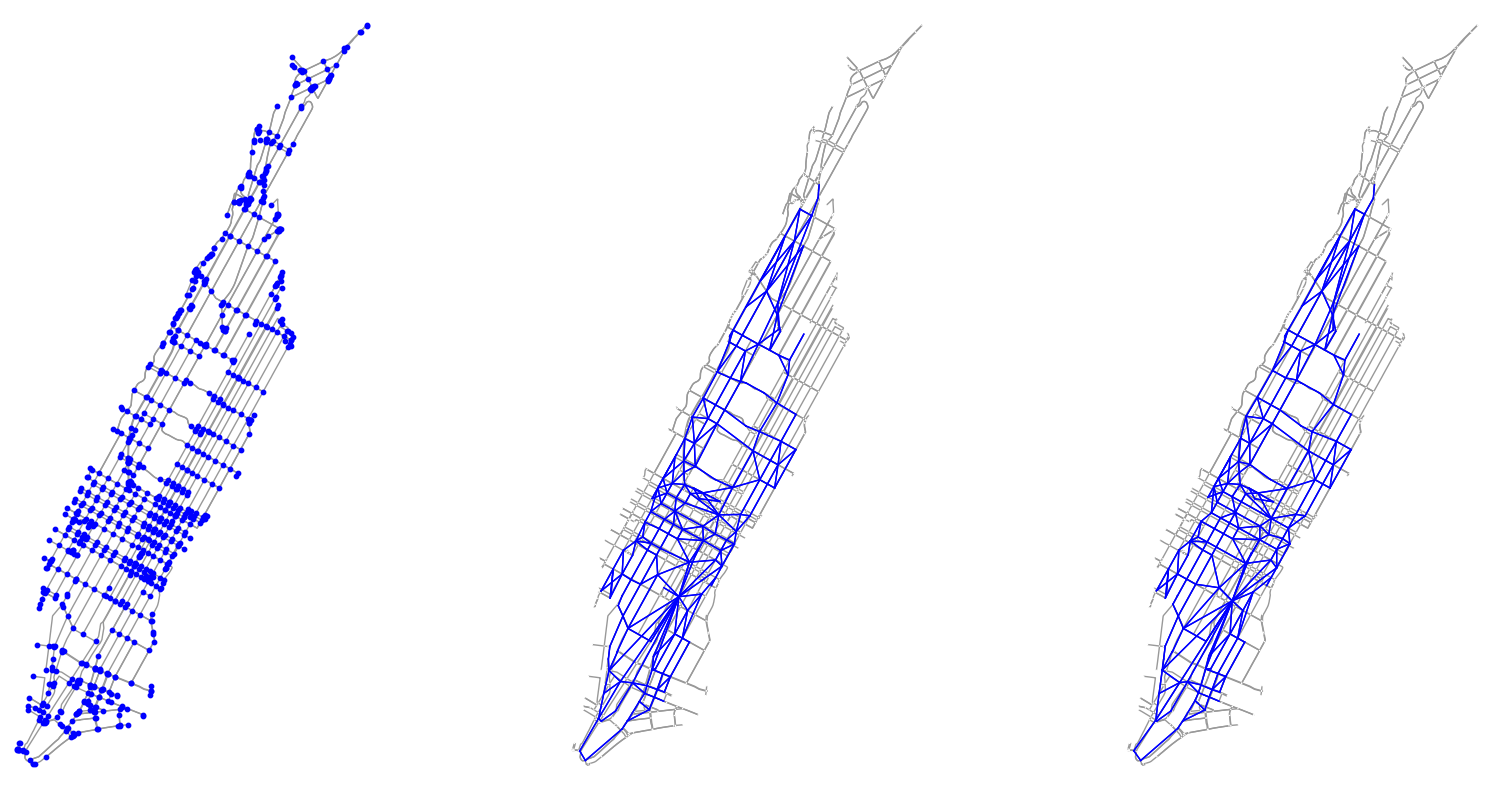

In [226]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 1 row, 2 columns
# Plot the second subplot
ax = axes[0]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for n in graph.nodes():
    ax.scatter(graph.nodes[n]['x'], graph.nodes[n]['y'], color='b', s=10)
# Plot the first subplot
ax = axes[1]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node1, node2 in backup_g.edges():
    
    x1, y1 =nyc_cluster_coordinates[node1]
    x2, y2 = nyc_cluster_coordinates[node2]
    #print(node1, node2)
    # Get node coordinates
    #x1, y1 = backup_g.nodes[node1]['x'], backup_g.nodes[node1]['y']
    #x2, y2 = backup_g.nodes[node2]['x'], backup_g.nodes[node2]['y']
    # Plot edge
    ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed


ax = axes[2]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node1, node2 in backup.edges():
    
    #x1, y1 =nyc_cluster_coordinates[node1]
    #x2, y2 = nyc_cluster_coordinates[node2]
    #print(node1, node2)
    # Get node coordinates
    x1, y1 = backup.nodes[node1]['x'], backup.nodes[node1]['y']
    x2, y2 = backup.nodes[node2]['x'], backup.nodes[node2]['y']
    # Plot edge
    ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed


plt.tight_layout() 
plt.savefig('cluster_visualization.png',dpi=300 )
plt.show()


In [227]:
len(backup.edges())

560

In [228]:
nyc_cluster_coordinates

{1: (-73.9398455, 40.8385135),
 2: (-73.94018316, 40.8354732),
 3: (-73.9421758, 40.8312341),
 4: (-73.9447637, 40.8240402),
 5: (-73.9527727, 40.810517000000004),
 6: (-73.9529182, 40.807775),
 7: (-73.95231522499999, 40.804432125),
 8: (-73.95529175, 40.799436799999995),
 9: (-73.95246315, 40.7982471),
 10: (-73.9495721, 40.7968677),
 11: (-73.94955666666667, 40.79361906666667),
 12: (-73.953030025, 40.78697535),
 13: (-73.95845492999999, 40.78019031),
 14: (-73.96051284999999, 40.77564731666667),
 15: (-73.96382071666666, 40.771103933333336),
 16: (-73.96683146666668, 40.766986124999995),
 17: (-73.97081333000001, 40.76367280999999),
 18: (-73.97117615925924, 40.760501751851855),
 19: (-73.97617937500002, 40.7578027375),
 20: (-73.97598901, 40.75443017),
 21: (-73.98008325, 40.7531465),
 22: (-73.98036711875, 40.7493201),
 23: (-73.98364078148148, 40.74115403333334),
 24: (-73.9883247, 40.7432751),
 25: (-73.9871802, 40.7332953),
 26: (-73.9915448, 40.7270946),
 27: (-73.99196757142

In [229]:
backup.nodes(data=True)

NodeDataView({1: {'x': -73.9398455, 'y': 40.8385135}, 2: {'x': -73.9401964, 'y': 40.8353595}, 3: {'x': -73.9429836, 'y': 40.8315772}, 8: {'x': -73.955363, 'y': 40.7994668}, 9: {'x': -73.9525303, 'y': 40.7982754}, 11: {'x': -73.9495058, 'y': 40.7936162}, 12: {'x': -73.9526692, 'y': 40.7866031}, 13: {'x': -73.959311, 'y': 40.780173}, 14: {'x': -73.9604288, 'y': 40.7756143}, 16: {'x': -73.9671492, 'y': 40.7667205}, 18: {'x': -73.9720733, 'y': 40.7596534}, 19: {'x': -73.975593, 'y': 40.7578582}, 20: {'x': -73.9757004, 'y': 40.7546355}, 22: {'x': -73.9800466, 'y': 40.7490228}, 23: {'x': -73.9842643, 'y': 40.7401675}, 24: {'x': -73.9883247, 'y': 40.7432751}, 26: {'x': -73.9915448, 'y': 40.7270946}, 27: {'x': -73.9925524, 'y': 40.7240472}, 28: {'x': -73.9939846, 'y': 40.7202997}, 29: {'x': -73.9947975, 'y': 40.718459}, 30: {'x': -73.991452, 'y': 40.7174356}, 31: {'x': -73.9883771, 'y': 40.7164549}, 32: {'x': -73.9923997, 'y': 40.7306021}, 33: {'x': -74.0006545, 'y': 40.7208548}, 34: {'x': -74

In [230]:
backup.nodes[1]['x']

-73.9398455

In [231]:
def apply_transformation_rule_triangle(graph):
    triangles = list(nx.cycle_basis(graph.to_undirected()))
    for triangle in triangles:
        if len(triangle) == 3:
            u, v, w = triangle
            if graph.has_edge(u, v) and graph.has_edge(v, w) and graph.has_edge(u, w):
                # Calculate midpoint between u and v
                x = (graph.nodes[w]['x'] + graph.nodes[v]['x']) / 2
                y = (graph.nodes[w]['y'] + graph.nodes[v]['y']) / 2

                # Add a new node with coordinates (x, y)
                new_node = len(graph) + 1  # Get a unique node ID
                graph.add_node(new_node, x=x, y=y)
                # Connect new node to u
                #graph.add_edge(new_node, u)
                graph.remove_edge(u,v)
                graph.remove_edge(u,w)

# Example usage:
# Assuming nyc_cluster_graph is already defined and has 'x' and 'y' attributes for nodes
apply_transformation_rule_triangle(backup)

In [185]:
backup.nodes(data=True)

NodeDataView({1: {'x': -73.9398455, 'y': 40.8385135}, 2: {'x': -73.9401964, 'y': 40.8353595}, 3: {'x': -73.9429836, 'y': 40.8315772}, 8: {'x': -73.955363, 'y': 40.7994668}, 9: {'x': -73.9525303, 'y': 40.7982754}, 11: {'x': -73.9495058, 'y': 40.7936162}, 12: {'x': -73.9526692, 'y': 40.7866031}, 13: {'x': -73.959311, 'y': 40.780173}, 14: {'x': -73.9604288, 'y': 40.7756143}, 16: {'x': -73.9671492, 'y': 40.7667205}, 18: {'x': -73.9720733, 'y': 40.7596534}, 19: {'x': -73.975593, 'y': 40.7578582}, 20: {'x': -73.9757004, 'y': 40.7546355}, 22: {'x': -73.9800466, 'y': 40.7490228}, 23: {'x': -73.9842643, 'y': 40.7401675}, 24: {'x': -73.9883247, 'y': 40.7432751}, 26: {'x': -73.9915448, 'y': 40.7270946}, 27: {'x': -73.9925524, 'y': 40.7240472}, 28: {'x': -73.9939846, 'y': 40.7202997}, 29: {'x': -73.9947975, 'y': 40.718459}, 30: {'x': -73.991452, 'y': 40.7174356}, 31: {'x': -73.9883771, 'y': 40.7164549}, 32: {'x': -73.9923997, 'y': 40.7306021}, 33: {'x': -74.0006545, 'y': 40.7208548}, 34: {'x': -74

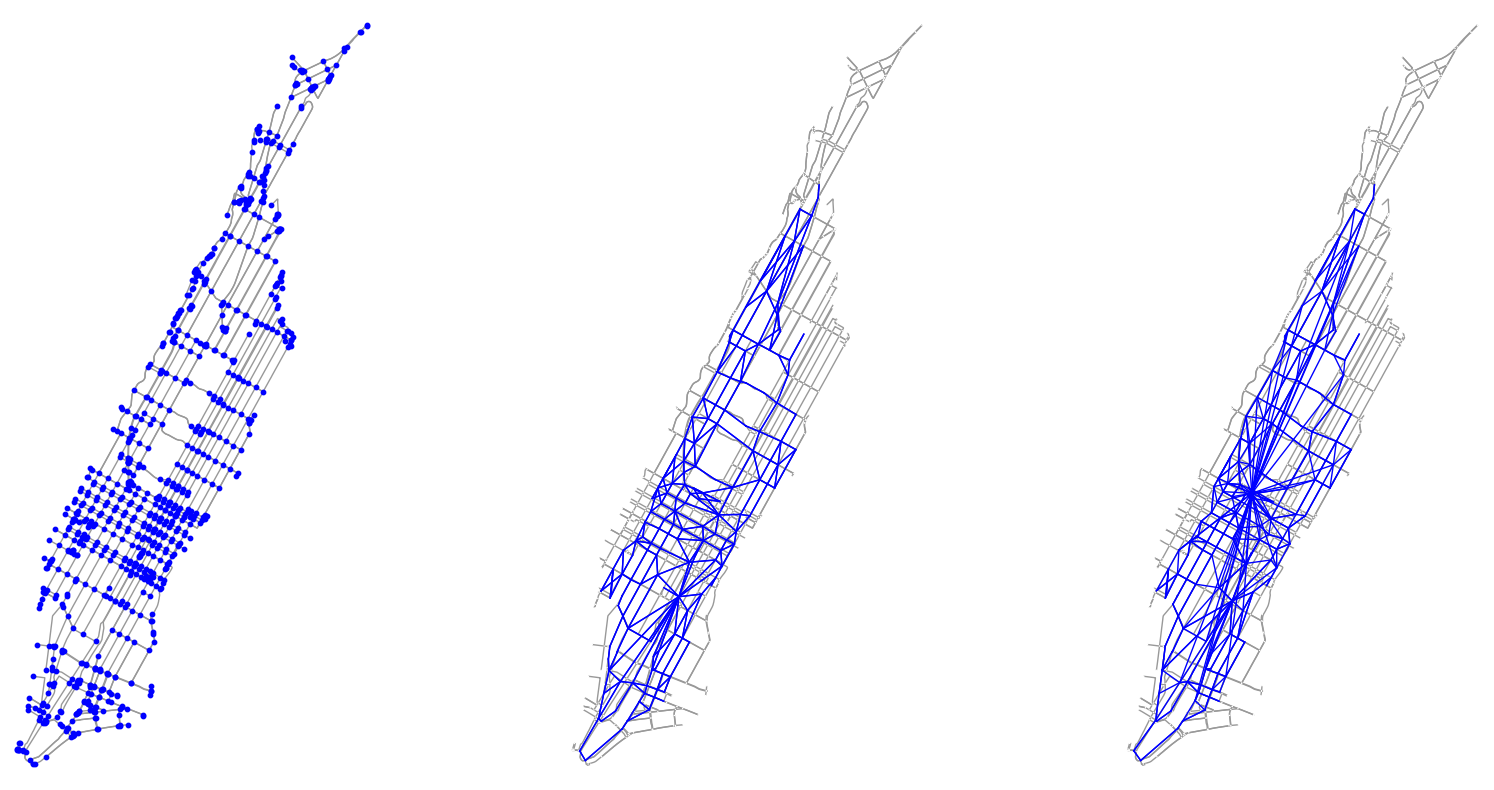

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # 1 row, 2 columns
# Plot the second subplot
ax = axes[0]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for n in graph.nodes():
    ax.scatter(graph.nodes[n]['x'], graph.nodes[n]['y'], color='b', s=10)
# Plot the first subplot
ax = axes[1]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node1, node2 in backup_g.edges():
    
    x1, y1 =nyc_cluster_coordinates[node1]
    x2, y2 = nyc_cluster_coordinates[node2]
    #print(node1, node2)
    # Get node coordinates
    #x1, y1 = backup_g.nodes[node1]['x'], backup_g.nodes[node1]['y']
    #x2, y2 = backup_g.nodes[node2]['x'], backup_g.nodes[node2]['y']
    # Plot edge
    ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed


ax = axes[2]
ox.plot_graph(graph, ax=ax, node_size=1, show=False, close=False)
for node1, node2 in backup.edges():
    
    #x1, y1 =backup[node1]
    #x2, y2 = backup[node2]
    #print(node1, node2)
    # Get node coordinates
    x1, y1 = backup.nodes[node1]['x'], backup.nodes[node1]['y']
    x2, y2 = backup.nodes[node2]['x'], backup.nodes[node2]['y']
    # Plot edge
    ax.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # You can adjust color and linewidth as needed


plt.tight_layout() 
plt.savefig('cluster_visualization.png',dpi=300 )
plt.show()


In [234]:
len(backup.edges())

506

In [52]:
len(nyc_graph.edges())

1622